In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams["axes.labelsize"] = 16

In [39]:
# print(plt.style.available)

# PCAs - general data exploration
* PUDs and TUDs
* Area inundation from SLR 

### PUD and TUD distributions for the PCA network

In [3]:
pudtable = pd.read_csv('../flickr/userdays_avg_annual_bypid.csv')
pudtable.rename(columns={'avg_ann_ud':'pud'}, inplace=True)

In [4]:
tudtable = pd.read_csv('../twitter/userdays_avg_annual_bypid.csv')
tudtable.rename(columns={'avg_ann_ud':'tud'}, inplace=True)

In [5]:
data = pudtable.merge(tudtable, on='pid')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd845a1eb00>], dtype=object)

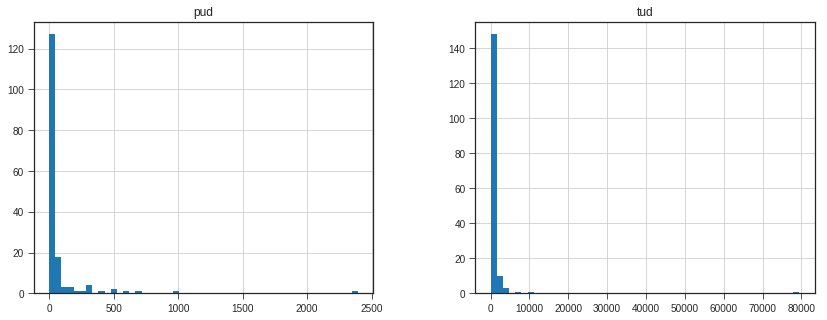

In [6]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.hist('pud', bins=50, ax=axs[0])
data.hist('tud', bins=50, ax=axs[1])

In [7]:
data['logpud'] = np.log1p(data['pud'])
data['logtud'] = np.log1p(data['tud'])

### PUD and TUD are correlated, but capture slightly different visitation patterns

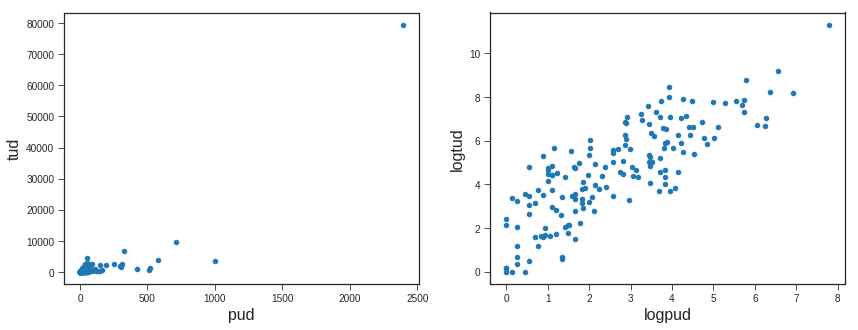

In [8]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pud', y='tud', ax=axs[0])
data.plot.scatter(x='logpud', y='logtud', ax=axs[1])

### PUD, TUD are influenced by area of PCA

In [9]:
pca_shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')

In [10]:
pca_shp['area_m2'] = pca_shp.area
data = data.merge(pca_shp[['area_m2', 'pid', 'name']], on='pid')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd848dca5f8>]], dtype=object)

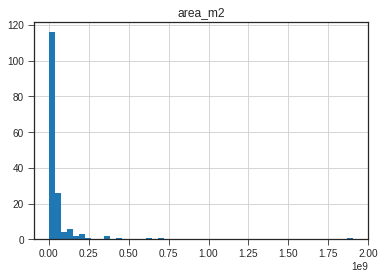

In [11]:
data.hist('area_m2', bins=50)

In [12]:
data['logarea'] = np.log1p(data['area_m2'])

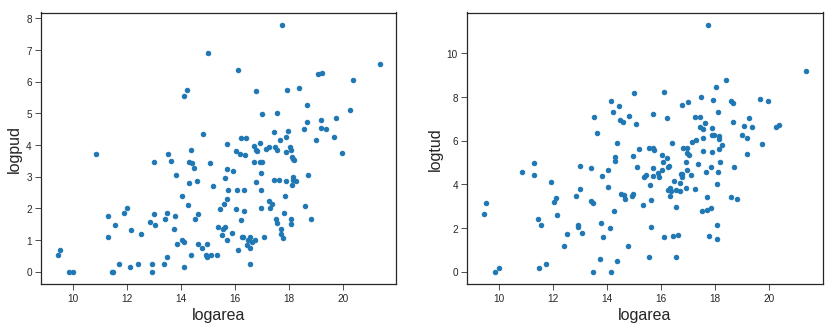

In [13]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='logarea', y='logpud', ax=axs[0])
data.plot.scatter(x='logarea', y='logtud', ax=axs[1])

In [14]:
data['pud_per_m2'] = data['pud']/data['area_m2']
data['tud_per_m2'] = data['tud']/data['area_m2']

#### break visitation density measures into deciles, so we can easily glance at the top 10% of PCAs, for example

In [15]:
data['pudden_tile'] = pd.qcut(data['pud_per_m2'], q=10, labels=False)
data['tudden_tile'] = pd.qcut(data['tud_per_m2'], q=10, labels=False)

In [16]:
data.head()

,pid,pud,tud,logpud,logtud,area_m2,name,logarea,pud_per_m2,tud_per_m2,pudden_tile,tudden_tile
0,0,23.285714,74.2,3.189888,4.320151,8.178311e+06,Sierra Vista,15.916996,2.847252e-06,0.000009,6,4
1,1,193.571429,2203.8,5.270799,7.698392,1.269679e+08,Bothe-Napa Valley State Park to Sugarloaf Ridg...,18.659445,1.524570e-06,0.000017,6,6
2,2,17.142857,892.6,2.898277,6.795258,4.532843e+07,Contra Costa County Agricultural Core,17.629445,3.781922e-07,0.000020,3,6
3,3,31.000000,186.2,3.465736,5.232178,1.632486e+06,"Central Marin Bayfront, Madera Bay Park",14.305615,1.898944e-05,0.000114,8,8
4,4,521.142857,1108.6,6.257941,7.011755,2.250422e+08,Coastal Access and Resource Protection,19.231798,2.315757e-06,0.000005,6,3


## Explore PCA SLR inundation

What percentage of each PCA (and the network as a whole) is vulnerable to SLR inundation?  
And how does recreation importance of PCAs vary with SLR vulnerability?

In [17]:
# SLR shapefiles, downloaded as .gdb from https://coast.noaa.gov/slrdata/
# explored in QGIS and exported shps for appropriate layers
slr = gpd.read_file('../slr/CA_MTR23_slr_6ft.shp')
slr.crs

{'init': 'epsg:26910'}

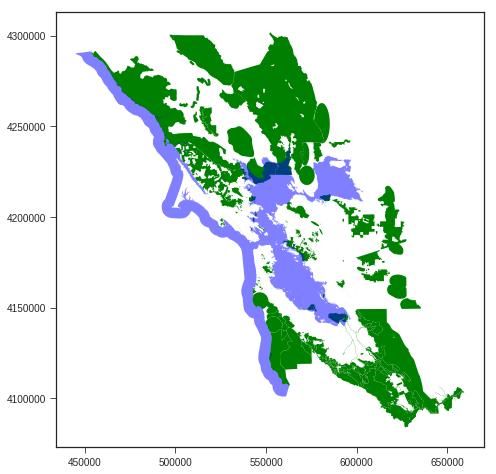

In [18]:
base = pca_shp.plot(color='green', edgecolor=None, figsize=(8,8))
slr.plot(ax=base, color='blue', alpha=0.5)

In [19]:
inundation = pd.read_csv('../pca/pca_area_inundated_slr6ft.csv')

In [20]:
inundation.shape[0] == data.shape[0]

True

In [21]:
data['flood_area'] = inundation['area_m2']
data['pr_flooded'] = data['flood_area'] / data['area_m2']

### PCAs most inundated -- sorted by proportion of their area that would flood with 6ft of SLR

In [22]:
data[['name', 'pud', 'tud', 'area_m2', 'flood_area', 'pr_flooded']].sort_values(by='pr_flooded', ascending=False).head(15)

,name,pud,tud,area_m2,flood_area,pr_flooded
3,"Central Marin Bayfront, Madera Bay Park",31.000000,186.2,1.632486e+06,1.621339e+06,0.993172
142,Site 1-Coyote Hills,7.285714,15.2,1.536279e+06,1.488682e+06,0.969018
88,Menlo Park and East Palo Alto Baylands,40.142857,183.6,1.084942e+07,1.026776e+07,0.946387
115,Baylands,150.428571,448.2,4.249035e+07,3.831035e+07,0.901625
137,"Central Marin Bayfront, Canalways",15.571429,157.2,1.593893e+06,1.418095e+06,0.889705
43,San Francisco Bay Area Water Trail,39.714286,96.6,5.157240e+04,4.403055e+04,0.853762
18,Point Edith Wetlands Area,1.142857,40.6,1.564446e+07,1.313765e+07,0.839764
6,Bothin Waterfront,32.142857,562.8,8.236991e+05,6.724061e+05,0.816325
100,Potential Oakland Gateway Area,39.571429,1199.2,7.507035e+05,6.077917e+05,0.809629
89,Oakland Priority Estuaries,254.857143,2437.0,1.361955e+06,1.007698e+06,0.739891


### SLR vulnerability related to Visitation Rates

In [23]:
# fig, axs = plt.subplots(1,2, figsize=(14,5))
# data.plot.scatter(x='pr_flooded', y='logpud', ax=axs[0])
# data.plot.scatter(x='pr_flooded', y='logtud', ax=axs[1])

FileNotFoundError: [Errno 2] No such file or directory: '..pca/figs/pca_pud_flood_scatter.png'

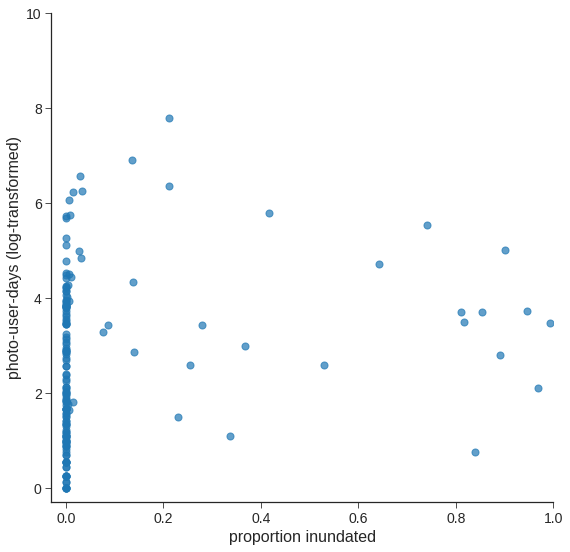

In [46]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
data.plot.scatter(x='pr_flooded', y='logpud', ax=ax, alpha=0.7, s=50)

# plt.yscale('log')

ax.set_xlim(-0.03, 1)
ax.set_ylim(-0.3, 10)
ax.tick_params(labelsize=14)


# Label the axes
ax.set(xlabel='proportion inundated',
       ylabel='photo-user-days (log-transformed)')

sns.despine()
plt.savefig('..pca/figs/pca_pud_flood_scatter.png', dpi=150)

In [26]:
output_notebook()

source = ColumnDataSource(data)
hover1 = HoverTool(tooltips=[("name", "@name")])
hover2 = HoverTool(tooltips=[("name", "@name")])

p = figure(plot_width=400, plot_height=400, tools=[hover1],
           title="SLR vulnerability related to Visitation Rates")

p.circle('pr_flooded', 'pud_per_m2', size=5, color='blue', alpha=0.5, source=source)
p.xaxis.axis_label = 'pr_flooded'
p.yaxis.axis_label = 'pud_per_m2'

p2 = figure(plot_width=400, plot_height=400, tools=[hover2],
           title="SLR vulnerability related to Visitation Rates")

p2.circle('pr_flooded', 'tud_per_m2', size=5, color='red', alpha=0.5, source=source)
p2.xaxis.axis_label = 'pr_flooded'
p2.yaxis.axis_label = 'tud_per_m2'

show(row(p, p2), notebook_handle=True)

Loading BokehJS ...

/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


### PCAs with greater than 30% area flooded and relatively dense visitation

In [27]:
(data[['name', 'pud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['pudden_tile'] >= 8)]
.sort_values(by='pud_per_m2', ascending=False)
)

,name,pud_per_m2,area_m2,pr_flooded
43,San Francisco Bay Area Water Trail,0.000770,5.157240e+04,0.853762
89,Oakland Priority Estuaries,0.000187,1.361955e+06,0.739891
100,Potential Oakland Gateway Area,0.000053,7.507035e+05,0.809629
6,Bothin Waterfront,0.000039,8.236991e+05,0.816325
33,Oakland Recreational Trails,0.000025,8.148263e+04,0.335776
3,"Central Marin Bayfront, Madera Bay Park",0.000019,1.632486e+06,0.993172
137,"Central Marin Bayfront, Canalways",0.000010,1.593893e+06,0.889705


In [28]:
(data[['name', 'tud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['tudden_tile'] >= 8)]
.sort_values(by='tud_per_m2', ascending=False)
)

,name,tud_per_m2,area_m2,pr_flooded
43,San Francisco Bay Area Water Trail,0.001873,5.157240e+04,0.853762
89,Oakland Priority Estuaries,0.001789,1.361955e+06,0.739891
100,Potential Oakland Gateway Area,0.001597,7.507035e+05,0.809629
33,Oakland Recreational Trails,0.000994,8.148263e+04,0.335776
6,Bothin Waterfront,0.000683,8.236991e+05,0.816325
3,"Central Marin Bayfront, Madera Bay Park",0.000114,1.632486e+06,0.993172
137,"Central Marin Bayfront, Canalways",0.000099,1.593893e+06,0.889705


In [29]:
data.to_csv('../pca/pca_data_4join.csv', index=False)

#### joining data to shp to make some maps in qgis

In [30]:
data = pd.read_csv('../pca/pca_data_4join.csv')
shp = gpd.read_file('../twitter/tud_nondissolved_pcas/shp/Priority_Conservation_Areas_current_pid.shp')

In [31]:
shp = shp.merge(data, on='pid')

In [32]:
shp.to_file('../pca/pca_current_visdata.shp')

### How much of entire PCA network will be flooded?
- there's some overlap in PCAs, for now we're ignoring it.
- What portion of the PUDs in the network are in places that will be flooded? begs for a finer resolution PUD grid.

#### Percent of PCA area inundated with a 6ft SLR scenario

In [38]:
sum(data['flood_area'])/sum(data['area_m2'])*100

3.5716042342024275